In [1]:
## Imports
%matplotlib inline
from skimage.transform import hough_line, hough_line_peaks
import skimage
import skimage.filters
import skimage.morphology
import itertools
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from time import time
from scipy.spatial import distance
time_notebook_begin = time()

In [2]:
## Configurable running parameters
show_images = True
plt.rcParams['figure.figsize'] = (5, 5)

In [3]:
files = os.listdir('./data')
print files
fn = 'data/sudoku7.jpg' #os.path.join('data',files[9]) 
print fn

['sudoku1.jpg', 'sudoku10.jpg', 'sudoku11.jpg', 'sudoku12.png', 'sudoku2.jpg', 'sudoku3.png', 'sudoku4.png', 'sudoku6.jpg', 'sudoku7.jpg', 'sudoku8.jpg', 'sudoku9.png']
data/sudoku7.jpg


39 milliseconds


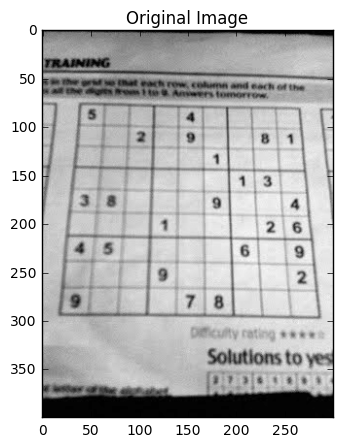

In [4]:
## Load image
start = time()

subsample = 1
image = scipy.ndimage.imread(fn, flatten=True, mode=None)
if subsample>1:
    image = image[::subsample, ::subsample]
print '{:d} milliseconds'.format(int((time()-start)*1000))
if show_images:
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.show()

9 milliseconds


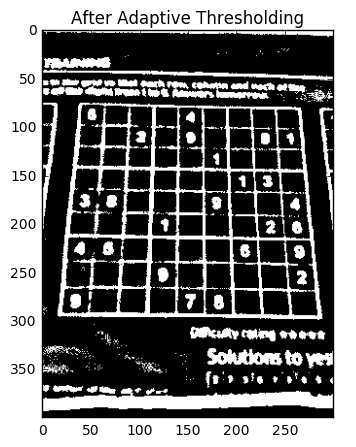

In [5]:
## Adaptively threshold image
start = time()

block_size = 2*(min(image.shape)/20)+1  # should be odd, we take it as about 10% of minimal side length
thresh = skimage.filters.threshold_adaptive(image,
                                            block_size=block_size,
                                            offset=5,
                                            method='mean',
                                            mode='reflect')
thresh = ~thresh

print '{:d} milliseconds'.format(int((time()-start)*1000))
if show_images:
    plt.imshow(thresh, cmap='gray')
    plt.title('After Adaptive Thresholding')
    plt.show()

6 milliseconds


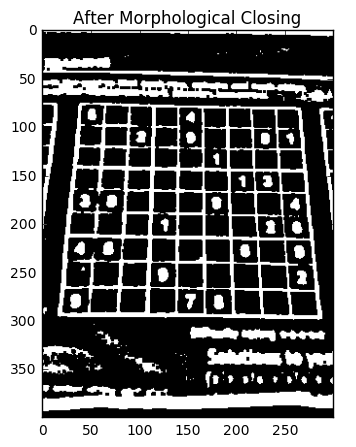

In [6]:
## Use morphological closing
start = time()

closed = skimage.morphology.binary_closing(thresh, skimage.morphology.square(3))

print '{:d} milliseconds'.format(int((time()-start)*1000))
if show_images:
    plt.imshow(closed, cmap='gray')
    plt.title('After Morphological Closing')
    plt.show()

52 milliseconds


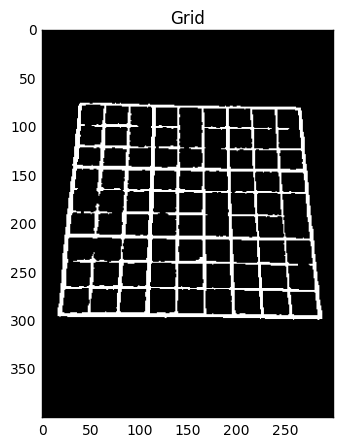

In [7]:
## Detect grid
# We obtain connected components of the image, and then search for the connected component of the grid.
# We should use the area of the convex hull for this task, but then if there's a frame around the board
# we'll detect it instead. However, notice that if we dilate the board, we'll get a lot of white pixels because
# of the grid lines inside the grid border, and this would not be the case for a frame around the board.
# Therefore, we make use of the area of the dilated connected component (this is what label_area() below returns)

def label_area(labeled, label):
    #t = time()
    x = (labeled==label)  # get component
    #first_approx = np.sum(np.any(x, axis=0))*np.sum(np.any(x, axis=1))  # area of enclosing rectangle (for continuous objects)
    #if first_approx < labeled.shape[0]*labeled.shape[1]/20:
    sides = np.array([np.sum(np.any(x, axis=axis)) for axis in [0,1]])
    if np.any(sides < np.array(labeled.shape)/4.):    
        #print 'easy, ',int(np.round((time()-t)*1000))
        return 0
    if np.sum(x) > labeled.shape[0]*labeled.shape[1] / 2.: # probably the background label
        #print 'very easy, ',np.sum(x), int(np.round((time()-t)*1000))
        return labeled.shape[0]*labeled.shape[1]
    square_size = min(labeled.shape)/30
    tmp = skimage.morphology.binary_dilation(x, skimage.morphology.square(square_size))
    #print 'hard, ',int(np.round((time()-t)*1000))
    return np.sum(tmp)

def get_grid_label(labeled, num_labels):
    areas = [label_area(labeled, label) for label in range(num_labels)]
    areas[np.argmax(areas)] = -1 # the maximum is the background
    return np.argmax(areas) # second maximum is the grid

start = time()

labeled, num_labels = skimage.morphology.label(closed, background=0,
                                               connectivity=2,
                                               return_num=True)
grid_label = get_grid_label(labeled, num_labels)
grid = (labeled==grid_label)

print '{:d} milliseconds'.format(int((time()-start)*1000))
if show_images:
    plt.imshow(grid, cmap='gray')
    plt.title('Grid')
    plt.show()

In [8]:
## Visualization of the labeled blobs
# areas = [label_area(labeled, label) for label in range(num_labels)]
# for l,ar in sorted(enumerate(areas), key=lambda p:p[1], reverse=True):
#     square_size = min(labeled.shape)/40
#     tmp = skimage.morphology.binary_dilation(labeled==l, skimage.morphology.square(square_size))
    
#     if ar==0:
#         break
#     plt.imshow(labeled==l, cmap='gray')
#     plt.title('label={}, area={}'.format(l, ar))
#     plt.show()
    
#     plt.imshow(tmp, cmap='gray')
#     plt.title('label={}, area={}, dilated'.format(l, ar))
#     plt.show()

3 milliseconds


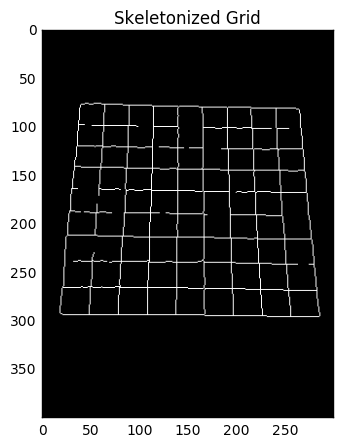

In [9]:
## Extract grid skeleton
start = time()

grid_skeleton = skimage.morphology.skeletonize(grid)

print '{:d} milliseconds'.format(int((time()-start)*1000))
if show_images:
    plt.imshow(grid_skeleton, cmap='gray')
    plt.title('Skeletonized Grid')
    plt.show()

36 milliseconds


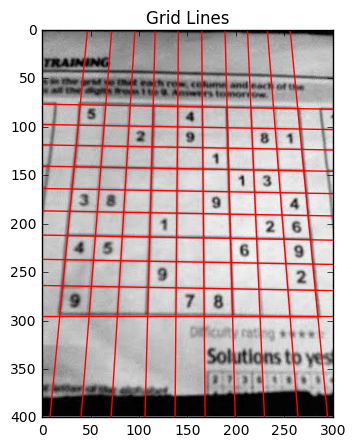

In [10]:
## Visualize grid lines on top of the input image
## This section is only for visualization, algorithmically redundant
    
def plot_line(angle, dist, cols):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - cols * np.cos(angle)) / np.sin(angle)
    plt.plot((0, cols), (y0, y1), '-r')
    
start = time()
if show_images:
    rows, cols = image.shape
    h, theta, d = hough_line(grid_skeleton)
    hspace, angles, dists = hough_line_peaks(hspace=h, angles=theta,
                                             dists=d, num_peaks=20, threshold=0)
    print '{:d} milliseconds'.format(int((time()-start)*1000))
    plt.imshow(image, cmap='gray')
    for angle,dist in zip(angles, dists):
        plot_line(angle, dist, cols)
    plt.title('Grid Lines')
    plt.axis((0, cols, rows, 0))
    plt.show()

19 milliseconds


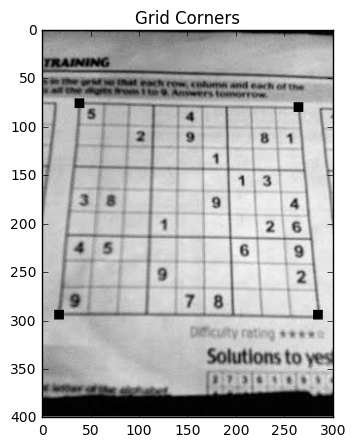

In [23]:
## Detect corners
start = time()


def get_grid_corners(img):
    h, theta, d = hough_line(grid_skeleton)
    hspace, angles, dists = hough_line_peaks(hspace=h, angles=theta,
                                             dists=d, num_peaks=20)

    angles[dists < 0] += np.pi
    dists = np.abs(dists)
    
    cluster1 = np.where(np.abs(np.rad2deg(angles))<45)[0]
    cluster2 = np.where(np.abs(np.rad2deg(angles))>=45)[0]

    cluster1_support_lines =\
        cluster1[np.argmin(dists[cluster1])],\
        cluster1[np.argmax(dists[cluster1])]
    cluster2_support_lines =\
        cluster2[np.argmin(dists[cluster2])],\
        cluster2[np.argmax(dists[cluster2])]
        
#     rows, cols = image.shape
#     plt.figure(figsize=(10,10));
#     plt.imshow(img, cmap='gray')
#     for i in cluster2:
#         angle1, dist1 = angles[i], dists[i]
#         print dist1
#         plot_line(angle1, dist1, cols)
#     plt.title('Grid Lines 2')
#     plt.axis((0, cols, rows, 0))
#     plt.show()
            
    corners = []
    for i in cluster1_support_lines:
        for j in cluster2_support_lines:
            angle1, dist1 = angles[i], dists[i]
            angle2, dist2 = angles[j], dists[j]

            mat = [[np.cos(angle1) , np.sin(angle1)],
                   [np.cos(angle2) , np.sin(angle2)]]
            ret = np.linalg.solve(mat, [dist1, dist2])
            corners += [map(lambda x:int(round(x)), ret)]
                        
    return corners


corners = get_grid_corners(grid_skeleton)
image2 = np.array(image)
for corner in corners:
    image2[corner[1]-5:corner[1]+5, corner[0]-5:corner[0]+5] = 0

print '{:d} milliseconds'.format(int((time()-start)*1000))
if show_images:
    plt.imshow(image2, cmap='gray')
    #corners[2], corners[3] = corners[3], corners[2]
    #
    #for p0,p1 in zip(corners, [corners[3] + corners[:-1]]):
    #    plt.plot((p0[0], p1[0]), (p0[1], p1[1]), '-r')
    plt.title('Grid Corners')
    plt.axis((0, cols, rows, 0))
    plt.show()

346 milliseconds


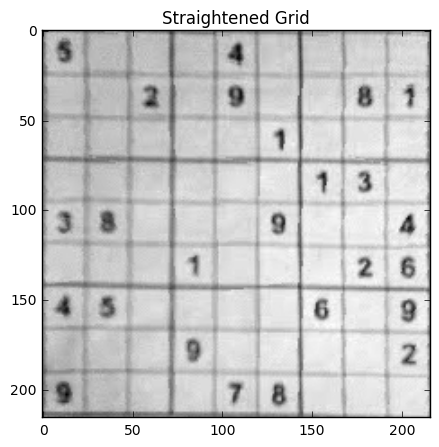

In [12]:
## Straighten the grid
start = time()

def grid_to_square(image, corners):
    # X = (ax+by+c)/(gx+hy+1)
    # Y = (dx+ey+f)/(gx+hy+1)
    #size = 99 # comfortable if it's divisible by 9
    l1 = distance.euclidean(corners[0], corners[1])
    l2 = distance.euclidean(corners[1], corners[3])
    l3 = distance.euclidean(corners[3], corners[2])
    l4 = distance.euclidean(corners[2], corners[0])
    size = int(np.round(min(l1, l2, l3 ,l4)/9))*9 # comfortable if it's divisible by 9
    ret = np.zeros((size,size))
    trans = skimage.transform.ProjectiveTransform()
    trans.estimate(np.array(corners),
                   np.array([(0,0),(0,size-1),(size-1,0),(size-1,size-1)]))
#     print '{:d} milliseconds'.format(int((time()-start)*1000))
    locations = np.array(list(itertools.product(range(size), range(size))))
    inverses = np.round(trans.inverse(locations)).astype(int)
#     print '{:d} milliseconds'.format(int((time()-start)*1000))
    
#     for loc1, loc2 in zip(locations, inverses):
#         ret[tuple(loc1)] = image.T[tuple(loc2)]
#     print '{:d} milliseconds'.format(int((time()-start)*1000))
    for i in range(size):
        ret[zip(*map(tuple, locations[i*size:(i+1)*size]))] = image.T[zip(*map(tuple, inverses[i*size:(i+1)*size]))]
    
    return ret.T

straightened = grid_to_square(image, corners)
print '{:d} milliseconds'.format(int((time()-start)*1000))
if show_images:
    plt.imshow(straightened, cmap='gray')
    plt.title('Straightened Grid')
    plt.show()

12 milliseconds


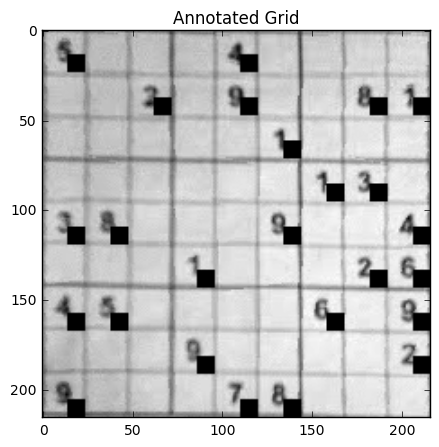

In [13]:
## Annotate grid
start = time()

def straight_to_board(straightened):
    size = straightened.shape[0]
    return [[straightened[i:i+size/9, j:j+size/9]
            for j in range(0,size,size/9)]
            for i in range(0,size,size/9)]
    
def cell_contains_digit(cell):
    block_size = 2*(min(image.shape)/20)+1
    thresh = skimage.filters.threshold_adaptive(cell,
                                            block_size=block_size,
                                            offset=5,
                                            method='mean',
                                            mode='reflect')
    size = cell.shape[0]
    ratio = np.mean(thresh[size/4:3*size/4 , size/4:3*size/4])
    #print ratio
    return ratio < 0.9

def annotate_cell(cell):
    size = cell.shape[0]
    ret = np.array(cell)
    ret[size*3/5:size , size*3/5:size] = 0
    return ret


def board_to_straight(board):
    size = np.sum(c.shape[0] for c in board[0])
    ret = np.zeros((size,size), dtype=board[0][0].dtype)
    for i in range(9):
        for j in range(9):
            ret[size*i/9:size*(i+1)/9 , size*j/9:size*(j+1)/9] = board[i][j]
    return ret

board = straight_to_board(straightened)

annotated = list(board)
for i in range(9):
    for j in range(9):
        if cell_contains_digit(board[i][j]):
            annotated[i][j] = annotate_cell(board[i][j])
straight_annotated = board_to_straight(annotated)

print '{:d} milliseconds'.format(int((time()-start)*1000))
if show_images:
    plt.imshow(straight_annotated, cmap='gray')
    plt.title('Annotated Grid')
    plt.show()

509 milliseconds


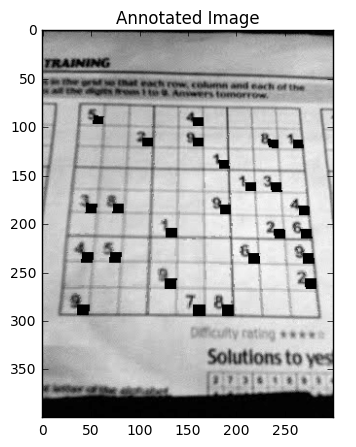

In [14]:
## Transform annotation back to original image
start = time()

def insert_straight_into_image(image, straightened, grid_skeleton, corners):
    global trans
    ret = np.array(image)
    l1 = distance.euclidean(corners[0], corners[1])
    l2 = distance.euclidean(corners[1], corners[3])
    l3 = distance.euclidean(corners[3], corners[2])
    l4 = distance.euclidean(corners[2], corners[0])
    size = int(np.round(min(l1, l2, l3 ,l4)/9))*9
    trans = skimage.transform.ProjectiveTransform()
    trans.estimate(np.array(corners),
                   np.array([(0,0),(0,size-1),(size-1,0),(size-1,size-1)]))
    
    conv_hull = skimage.morphology.convex_hull_image(grid_skeleton)
    inverses = np.array(list((zip(np.where(conv_hull))))).squeeze()
    inverses = inverses.T
    locations = np.round(trans(inverses[:,::-1])).astype(int)
    
    for loc1, loc2 in zip(locations, inverses):
        if loc1[0]>=0 and loc1[0]<size and loc1[1]>=0 and loc1[1]<size:
            ret[tuple(loc2)] = straightened[tuple(loc1)[::-1]]
    return ret

image_annotated = insert_straight_into_image(image,
                                             straight_annotated,
                                             grid_skeleton,
                                             corners)
print '{:d} milliseconds'.format(int((time()-start)*1000))
if show_images:
    plt.imshow(image_annotated, cmap='gray')
    plt.title('Annotated Image')
    plt.show()

In [15]:
## Test insertion into image
# start = time()

# ret = insert_straight_into_image(image, straightened, grid_skeleton, corners)
# plt.imshow(ret, cmap='gray')
# plt.title('Insertion to Image Test')
# plt.show()
# print '{:d} milliseconds'.format(int((time()-start)*1000))

In [16]:
print 'Full notebook time: {:.4} seconds '.format(time()-time_notebook_begin)

Full notebook time: 5.023 seconds 
